In [1]:
import json
import logging
import matplotlib.pyplot as plt

from AgentFactory import AgentFactory
from src.utils import clear_json
from PIL import Image

logging.basicConfig(level=logging.INFO)

/home/youyuan/miniconda3/envs/Iris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define the TranscreationEvaluator class, following [S Khanuja's approach](https://arxiv.org/abs/2412.13717) to utilize a LLM for evaluating transcreation. 

In [2]:
class TranscreationEvaluator:
    def __init__(self, config):
        self.agent_factory = AgentFactory()
        self.agent = self.agent_factory.create_agent(config)

    def cost(self):
        return self.agent.llm.total_cost()

    def evaluate(self, img1_path, img2_path, target_country, category = None):
        
        category_patch = f" and its category '{category}'"

        prompt = {   
            "culture-relevance":[
                {"type": "text", "text": f"You will be given two images. You have to assess how culturally relevant both images are with respect to the culture of {target_country}."},
                {"type": "text", "text": f"Please explain your reasoning step by step for both images, specifically considering cultural symbols, styles, traditions, or any features that align with the culture of the speaking population of {target_country}.\n"},
                {"type": "text", "text": f"For each image, the final score should be a number between 1 to 5, where 1 and 5 mean the following:\n"},
                {"type": "text", "text": f"1 = Not culturally relevant,\n"},
                {"type": "text", "text": f"5 = Culturally relevant.\n"},
                {"type": "image"},
                {"type": "image"},
                {"type": "text", "text": f"The output should be a JSON object ONLY with the following format:\n"},
                {"type": "text", "text": "{\"first_reasoning\": ..., \"first_score\": number, \"second_reasoning\": ..., \"second_score\": number}\n"},
            ],
            "semantic":[
                {"type": "text", "text": f"Given the input image{category_patch}, determine if the comparison image belongs to the same category as the input.\n"},
                {"type": "text", "text": f"Please explain your reasoning step by step, and provide a final score at the end.\n"},
                {"type": "text", "text": f"The score should be between 1 and 5, where:\n"},
                {"type": "text", "text": f"1 = Dissimilar Category,\n"},
                {"type": "text", "text": f"5 = Same Category.\n"},
                {"type": "image"},
                {"type": "image"},
                {"type": "text", "text": f"The output should be a JSON object ONLY with the following format:\n"},
                {"type": "text", "text": "{\"reasoning\": ..., \"score\": number}\n"},
            ],
            "visual":[
                {"type": "text", "text": f"Given the input image, determine if there are visual changes in the second image as compared to the first."},
                {"type": "text", "text": f"Please explain your reasoning step by step, and provide a final score at the end."},
                {"type": "text", "text": f"The score should be between 1 and 5, where:\n1 = No visual change,\n5 = High visual changes."},
                {"type": "image"},
                {"type": "image"},
                {"type": "text", "text": "The output should be a JSON object ONLY with the following STRICT format: {\"reasoning\": ..., \"score\": number}"},
            ],
        }
        images = [img1_path, img2_path]

        answer = {}

        for k,v in prompt.items():
            self.agent.reset_msg_history()
            try:
                response, text = self.agent.get_response(v, images = images)
                text = clear_json(text)
                result = json.loads(text)
                answer[k] = result
            except Exception as e:
                logging.error(f"Error processing {k} evaluation: {e}")

        return answer

    

Loading the evaluator.

In [3]:
# config_path: str = "configs/conf_Gemini.json"
config_path: str = "configs/conf_GPT.json"
config = json.load(open(config_path, "r"))
config = config["model"]

evaluator = TranscreationEvaluator(config)

Loading the test images.

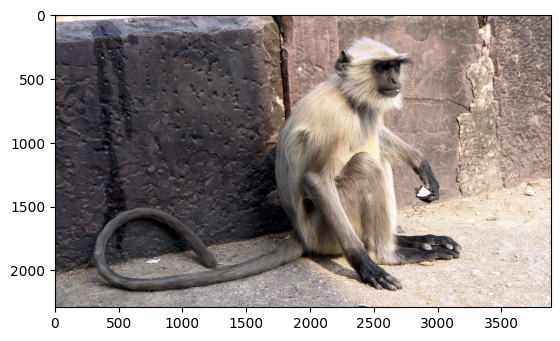

In [4]:
from src.WebImage import WebImage
from assets.concept.transcreation_dataset import TranscreationDataset

dataset = TranscreationDataset("assets/concept/")

source_country = "japan"
target_country = "india"
item_idx = 11
item = dataset['india']["japan"][item_idx]

image_handler = WebImage(country_f=source_country, country_t=target_country)
local_path = image_handler.read_image_fp(item["path"])

img1 = Image.open(local_path)
plt.imshow(img1)

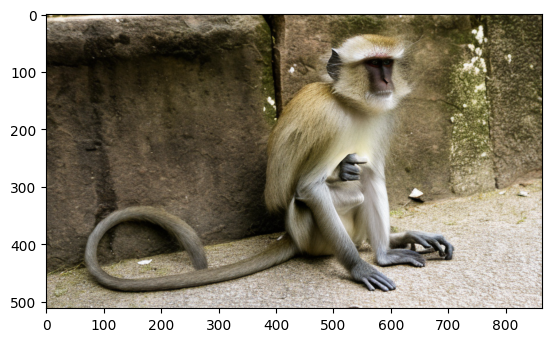

In [5]:
transcreation_path = image_handler.read_image_fp(item["transcreations"][1]["path"])
img2 = Image.open(transcreation_path)
plt.imshow(img2)

Run the evaluation.

In [6]:
evaluation_results = evaluator.evaluate(local_path, transcreation_path, target_country)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
ERROR:root:Error processing visual evaluation: Invalid \escape: line 2 column 84 (char 85)


In [7]:
for k, v in evaluation_results.items():
    print(f"{k} evaluation:")
    if isinstance(v, dict):
        for sub_k, sub_v in v.items():
            print(f"  {sub_k}: {sub_v}")
    else:
        print(f"  {v}")

culture-relevance evaluation:
  first_reasoning: The first image shows a langur, which is culturally significant in India. Langurs are often associated with the Hindu deity Hanuman, who is revered and considered a symbol of strength, perseverance, and devotion. Langurs are commonly found in many parts of India and often seen in urban and temple areas. This connects the image strongly with Indian cultural and religious symbolism.
  first_score: 5
  second_reasoning: The second image also depicts a monkey. While not as distinct as the langur associated with Hanuman, monkeys in general hold cultural and religious importance in India. They are common in Indian mythology and are often featured in stories and temples. However, without a specific link to Hanuman or a particular type like the langur, the cultural relevance is slightly less direct.
  second_score: 4
semantic evaluation:
  reasoning: The input and comparison images both depict monkeys. The general features such as the long tails

In [9]:
print(evaluator.agent.llm.input_tokens)
print(evaluator.agent.llm.output_tokens)
print(evaluator.agent.llm.total_cost())

4955
409
0.016477500000000003
